In [1]:
from pathlib import Path
from typing import List

import fsspec
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pyproj import CRS, Transformer

from nsidc_projections.grid import to_cartopy
from ros_database.ims_snow.ims_crs import IMS4kmGrid
from notebooks.utils import plot_ims_snow_and_ice, get_extent

DATAPATH = Path.home() / "src" / "rain_on_snow_database" / "data" / "test_data"

fs = fsspec.filesystem('file')

In [2]:
test_point = {
    "Norton Sound": (-163.01706271914878, 64.54757445721512),
    "Cambridge Bay": (-105.05586791647777, 69.11608384685066),
    "Clyde River": (-68.59767446082255, 70.47531698648856),
    "Tiksi": (128.76156219329152, 71.70659836968615),
}

In [3]:
filepath = list(DATAPATH.glob("*4km*.nc.gz"))[0]

ds_4km = xr.open_dataset(fs.open(filepath, compression="gzip"), decode_coords="all")
ds_4km

<xarray.Dataset> Size: 151MB
Dimensions:             (x: 6144, y: 6144, time: 1)
Coordinates:
  * x                   (x) float32 25kB -1.229e+07 -1.228e+07 ... 1.229e+07
  * y                   (y) float32 25kB -1.229e+07 -1.228e+07 ... 1.229e+07
  * time                (time) datetime64[ns] 8B 2023-02-01
    projection          |S1 1B ...
Data variables:
    IMS_Surface_Values  (time, y, x) float32 151MB ...
Attributes: (12/49)
    Conventions:                CF-1.6, ACDD-1.3
    title:                      NOAA/NESDIS Interactive Multisensor Snow and ...
    summary:                    This file contains a map of snow cover and ic...
    keywords:                   EARTH SCIENCE > CRYOSPHERE > SEA ICE > ICE EX...
    keywords_vocabulary:        NASA Global Change Master Directory (GCMD) Ke...
    ncei_template_version:      NCEI_NetCDF_Grid_Template_v2.0
    ...                         ...
    metadata_link:              https://nsidc.org/data/G02156
    naming_authority:           org.nsidc
    references:                 Ramsay, B. H. (1998). The interactive multise...
    history:                    01 February 2023 00:33Z: NetCDF file generate...
    source:                     Analysts at the United States National Ice Ce...
    comment:                    The IMS product has changed versions and reso...

In [4]:
6356752.314245

6356752.314245

In [5]:
filepath = list(DATAPATH.glob("*1km*.nc.gz"))[0]

ds_1km = xr.open_dataset(fs.open(filepath, compression="gzip"), decode_coords="all")
ds_1km

<xarray.Dataset> Size: 2GB
Dimensions:             (x: 24576, y: 24576, time: 1)
Coordinates:
  * x                   (x) float32 98kB -1.229e+07 -1.229e+07 ... 1.229e+07
  * y                   (y) float32 98kB -1.229e+07 -1.229e+07 ... 1.229e+07
  * time                (time) datetime64[ns] 8B 2023-02-01
    projection          |S1 1B ...
Data variables:
    IMS_Surface_Values  (time, y, x) float32 2GB ...
Attributes: (12/49)
    Conventions:                CF-1.6, ACDD-1.3
    title:                      NOAA/NESDIS Interactive Multisensor Snow and ...
    summary:                    This file contains a map of snow cover and ic...
    keywords:                   EARTH SCIENCE > CRYOSPHERE > SEA ICE > ICE EX...
    keywords_vocabulary:        NASA Global Change Master Directory (GCMD) Ke...
    ncei_template_version:      NCEI_NetCDF_Grid_Template_v2.0
    ...                         ...
    metadata_link:              https://nsidc.org/data/G02156
    naming_authority:           org.nsidc
    references:                 Ramsay, B. H. (1998). The interactive multise...
    history:                    01 February 2023 00:35Z: NetCDF file generate...
    source:                     Analysts at the United States National Ice Ce...
    comment:                    The IMS product has changed versions and reso...

<GeoAxes: title={'center': 'IMS Snow and Ice Cover 4km'}, xlabel='x coordinate of projection\n[metre]', ylabel='y coordinate of projection\n[metre]'>

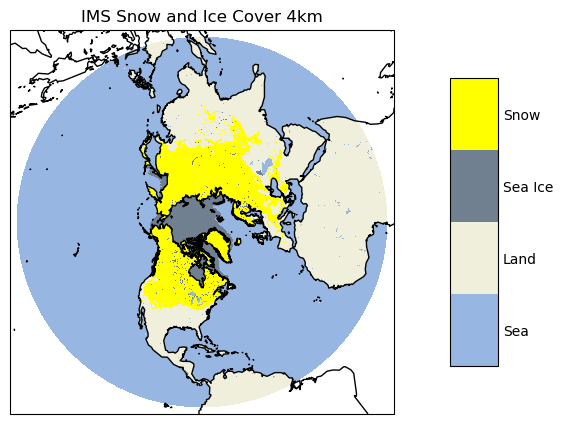

In [6]:
plot_ims_snow_and_ice(ds_4km.IMS_Surface_Values.squeeze(), title="IMS Snow and Ice Cover 4km")

<GeoAxes: title={'center': 'IMS Snow and Ice Cover 1km'}, xlabel='x coordinate of projection\n[metre]', ylabel='y coordinate of projection\n[metre]'>

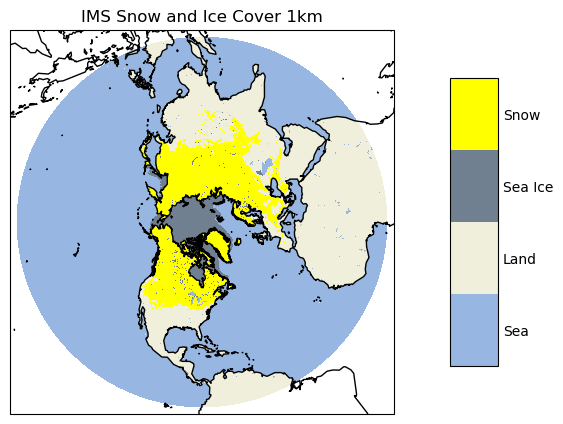

In [7]:
plot_ims_snow_and_ice(ds_1km.IMS_Surface_Values.squeeze(), title="IMS Snow and Ice Cover 1km")

In [8]:
location = "Norton Sound"

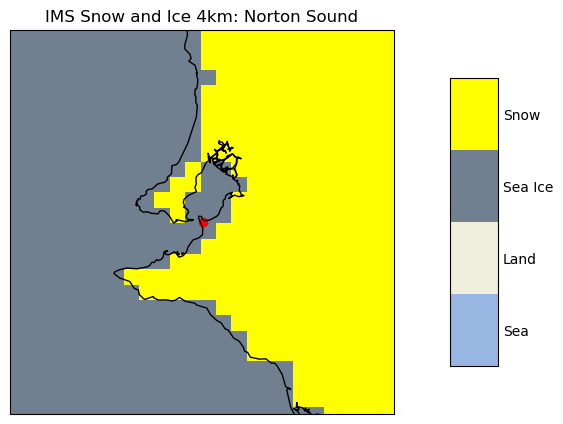

In [9]:
extent = get_extent(test_point[location], ds_4km, fov=50000.)
ax = plot_ims_snow_and_ice(ds_4km.IMS_Surface_Values.squeeze(), title=f"IMS Snow and Ice 4km: {location}", extent=extent)
ax.scatter(*test_point[location], marker='o', color="red", transform=ccrs.PlateCarree())

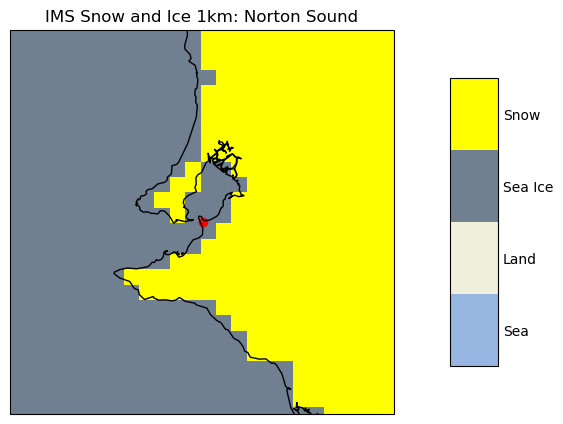

In [10]:
extent = get_extent(test_point[location], ds_1km, fov=50000.)
ax = plot_ims_snow_and_ice(ds_1km.IMS_Surface_Values.squeeze(), title=f"IMS Snow and Ice 1km: {location}", extent=extent)
ax.scatter(*test_point[location], marker='o', color="red", transform=ccrs.PlateCarree())

In [47]:
xmin, xmax, ymin, ymax = ax.get_extent()
print(xmin, xmax, ymin, ymax)

-2725522.2172892056 -2625522.2172892056 -377704.06581023004 -277704.06581023004


In [48]:
xg =  ds_1km.x.sel(x=slice(xmin,xmax)).values
yg =  ds_1km.y.sel(y=slice(ymin,ymax)).values

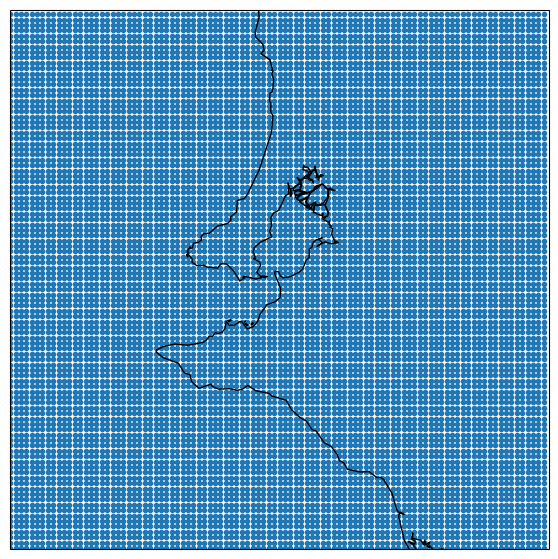

In [63]:
proj = ccrs.Stereographic(central_latitude=90., 
                              central_longitude=-80., 
                              true_scale_latitude=60.)
coastline = cfeature.GSHHSFeature()

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection=proj)
ax.set_extent([xmin, xmax, ymin, ymax], proj)
ax.add_feature(coastline)

a, b = list(zip(*points))
#[ax.axvline(xxg) for xxg in xg];
#[ax.axhline(yyg) for yyg in yg];
ax.scatter(a, b, marker='.')

In [50]:
from shapely.geometry import MultiPolygon, MultiPoint, Point

In [51]:
multi_coast = MultiPolygon(coastline.geometries())

Test for Goluvin

In [52]:
multi_coast.contains(Point(*test_point[location]))

True

In [75]:
multi_coast.within(Point(*test_point[location]))

False

In [76]:
multi_coast.contains_properly(Point(*test_point[location]))

True

In [66]:
points = [IMS4kmGrid.xy_to_latlon(xxg, yyg) for xxg, yyg in product(xg, yg)]

In [77]:
%%time
from itertools import product
is_land = np.array([multi_coast.contains_properly(Point(*point)) for point in points])

CPU times: user 792 ms, sys: 0 ns, total: 792 ms
Wall time: 792 ms


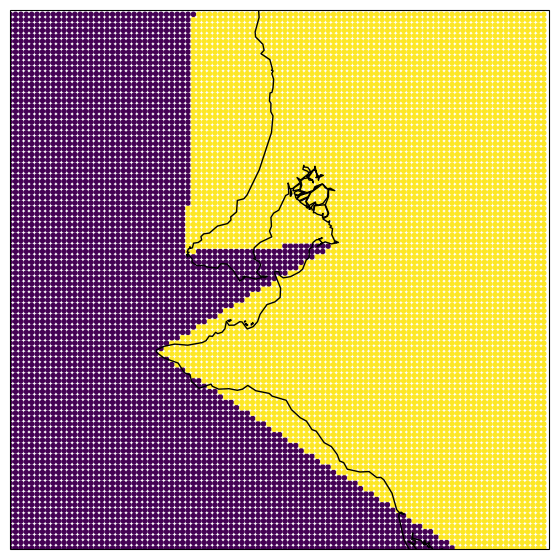

In [78]:
proj = ccrs.Stereographic(central_latitude=90., 
                              central_longitude=-80., 
                              true_scale_latitude=60.)
coastline = cfeature.GSHHSFeature()

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection=proj)
ax.set_extent([xmin, xmax, ymin, ymax], proj)
ax.add_feature(coastline)

a, b = list(zip(*points))
#[ax.axvline(xxg) for xxg in xg];
#[ax.axhline(yyg) for yyg in yg];
ax.scatter(a, b, c=is_land, marker='.', transform=ccrs.PlateCarree())

In [59]:
is_land

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])